<a href="https://colab.research.google.com/github/Abbhiraami/ML_AI_masters/blob/main/case_study/lending_club_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Lending club case study

You work for a consumer finance company which specialises in lending various types of loans to urban customers. When the company receives a loan application, the company has to make a decision for loan approval based on the applicant’s profile. Two types of risks are associated with the bank’s decision:

1. If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company

2. If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company

**Expected solution of this problem statement**: To understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment.

In [ ]:
### Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

print("This is a test message.")
warnings.warn("This is a warning message that will be ignored.")
print("End of program.")

This is a test message.
End of program.


##### Loading the data

In [ ]:
loan_data=pd.read_csv('loan.csv')
print('Shape of the data:',loan_data.shape)
loan_data.shape

print('Info:')
loan_data.info()
print(f'''\nData before cleansing \n
        Number of columns: {loan_data.shape[1]}
        NUmber of unique records: {loan_data.shape[0]}''')

Shape of the data: (39717, 111)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB

Data before cleansing 

        Number of columns: 111
        NUmber of unique records: 39717


#### 1. Data Cleaning

1. It is not ideal to remove outliers from financial instituition/ banking data. Because defaulting pattern can be found majorily in outliers. Therefore, choosing not to remove outliers.
2. Columns with 50% blanks and zeros are removed
3. Few columns data types were corrected
4. Some numerical fields were categorized to perform segemented bivariate analysis

In [ ]:
# Handling missing values (customize based on missing data analysis)
# For example, drop columns with more than 50% missing values
missing_threshold = 0.5 * loan_data.shape[0]
loan_db = loan_data.dropna(thresh=missing_threshold, axis=1)
loan_db.drop_duplicates(inplace=True)
print(f'''\nData after cleansing \n
        Number of columns: {loan_db.shape[1]}
        NUmber of unique records: {loan_db.shape[0]}''')


Data after cleansing 

        Number of columns: 54
        NUmber of unique records: 39717


In [ ]:

func=lambda b: float(b.replace('%',''))
loan_db['int_rate_num']=loan_db['int_rate'].apply(func)
loan_db['title']=loan_db['title'].replace('Loan','')
### Categorizing annual incomes to see charged_off customers
loan_db['annual_inc_cat']=pd.qcut(loan_db.annual_inc,q=5)


#### 2. Data Analysis

1. Univariate Analysis: Overall default rate, employee's year and employee's title
2. Bivariate Analysis: State, int-rate, grade, annual income and sub-grade wise default rates
3. Multi-variate Analysis: Numerical variables and it's correlation amongst each other

Overall 14.17% of the customers have defaulted


Text(0, 0.5, 'No of customers')

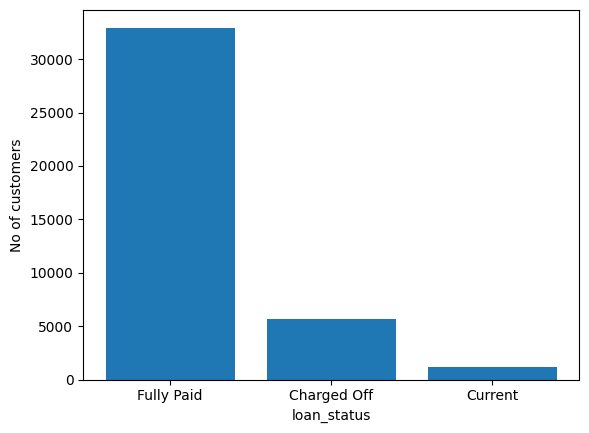

In [ ]:
loan_status=loan_db['loan_status'].value_counts()/loan_db['loan_status'].value_counts().sum()
print(f'Overall {loan_status[1]*100:.2f}% of the customers have defaulted')
pp.bar(loan_db.loan_status.value_counts().index,loan_db.loan_status.value_counts().values)
pp.xlabel('loan_status')
pp.ylabel('No of customers')

![image.png](attachment:94351aa8-98cb-4d35-a37f-19f626a2f171.png)

Overall default percentage is 14.17%

Text(0.5, 1.0, 'Employment history proportion')

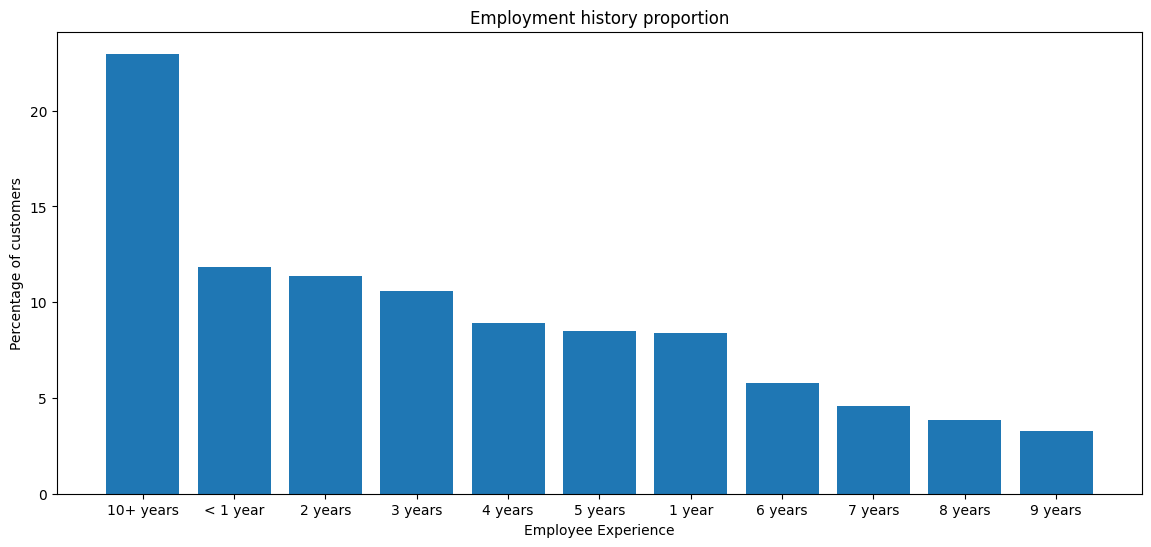

In [ ]:
emp_exp=pd.DataFrame(loan_db['emp_length'].value_counts()/loan_db['emp_length'].value_counts().sum())
pp.subplots(figsize=(14,6))
pp.bar(emp_exp.index,emp_exp.emp_length*100)
pp.xlabel('Employee Experience')
pp.ylabel('Percentage of customers')
pp.title('Employment history proportion')

#### State-wise charged-off customers pattern
The idea here is to take top 10 countries which has more defaulters provided the total customer per state

In [ ]:
### Sumarizing based on demography ###
loan_addr=loan_db.groupby(['loan_status','addr_state']).agg({'id':'count','loan_amnt':'sum'}).reset_index().rename(columns={'id':'status_cust'})
### Computing total customers state wise ###
state_wise=loan_db.groupby(['addr_state']).agg({'id':'count','loan_amnt':'sum'}).reset_index().rename(columns={'id':'total_cust','loan_amnt':'total_loan_amnt'})
### Merging them to compute further metrices ###
full_table=loan_addr.merge(state_wise[['addr_state','total_cust','total_loan_amnt']],on='addr_state',how="left")
### Proportion of loan_statusn ###
full_table['prop']=full_table['status_cust']/full_table['total_cust']
full_table

,loan_status,addr_state,status_cust,loan_amnt,total_cust,total_loan_amnt,prop
0,Charged Off,AK,15,210875,80,1039300,0.187500
1,Charged Off,AL,54,709025,452,5125625,0.119469
2,Charged Off,AR,27,274350,245,2602075,0.110204
3,Charged Off,AZ,123,1475700,879,9623625,0.139932
4,Charged Off,CA,1125,13739475,7099,80359325,0.158473
...,...,...,...,...,...,...,...
135,Fully Paid,VT,47,424500,54,504100,0.870370
136,Fully Paid,WA,691,7113700,840,9186650,0.822619
137,Fully Paid,WI,377,4042975,460,5191950,0.819565
138,Fully Paid,WV,151,1561175,177,1922050,0.853107


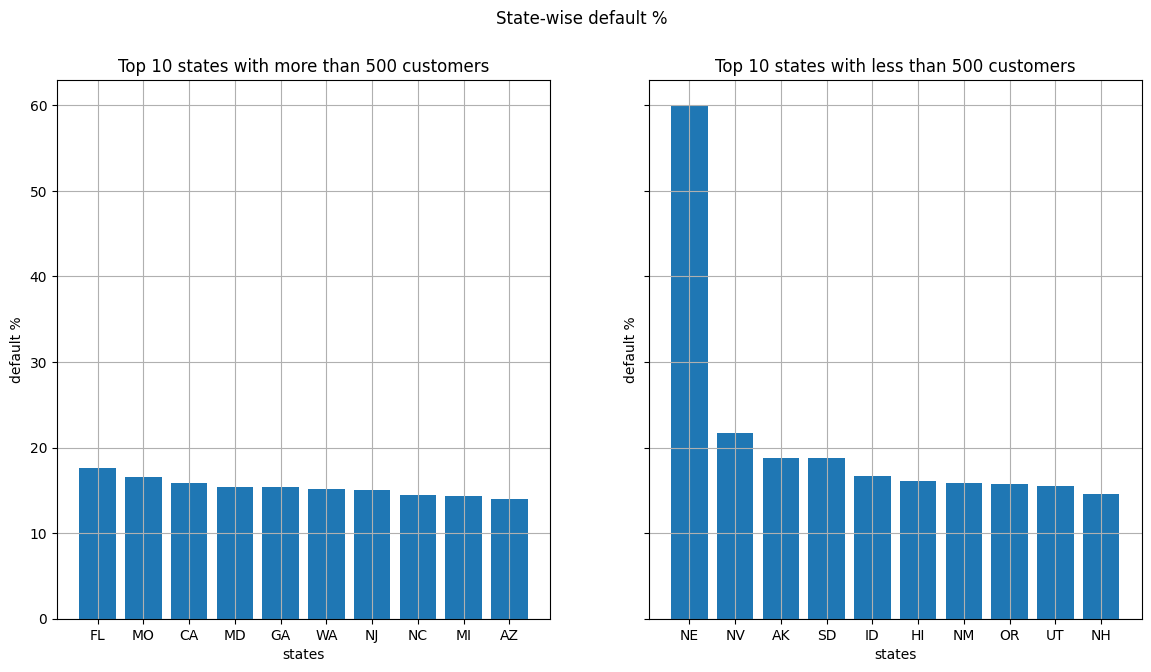

In [ ]:
fig,ax = pp.subplots(1,2,figsize=(14,7),sharey=True)
fig.suptitle('State-wise default %')
status=["Charged Off", "Fully Paid"]
for i,axes in zip((">500","<=500"),ax.ravel()):
    if i==">500":
        strg="total_cust>500"
        title="Top 10 states with more than 500 customers"
    else:
        strg="total_cust<=500"
        title="Top 10 states with less than 500 customers"
    ### Filtering out total customers with less than 100
    data=full_table.query(f'loan_status=="Charged Off" & {strg}').sort_values('prop',ascending=False).head(10)
    # print(data)
    axes.bar(data['addr_state'],100*data['prop'])
    axes.set_xlabel('states')
    axes.set_ylabel('default %')
    axes.set_title(title)
    axes.grid()


For both new and existing loans of state NE, implement additional checks, as it has a default rate of 60%

#### Charged off & loan_amount distribution on grades level

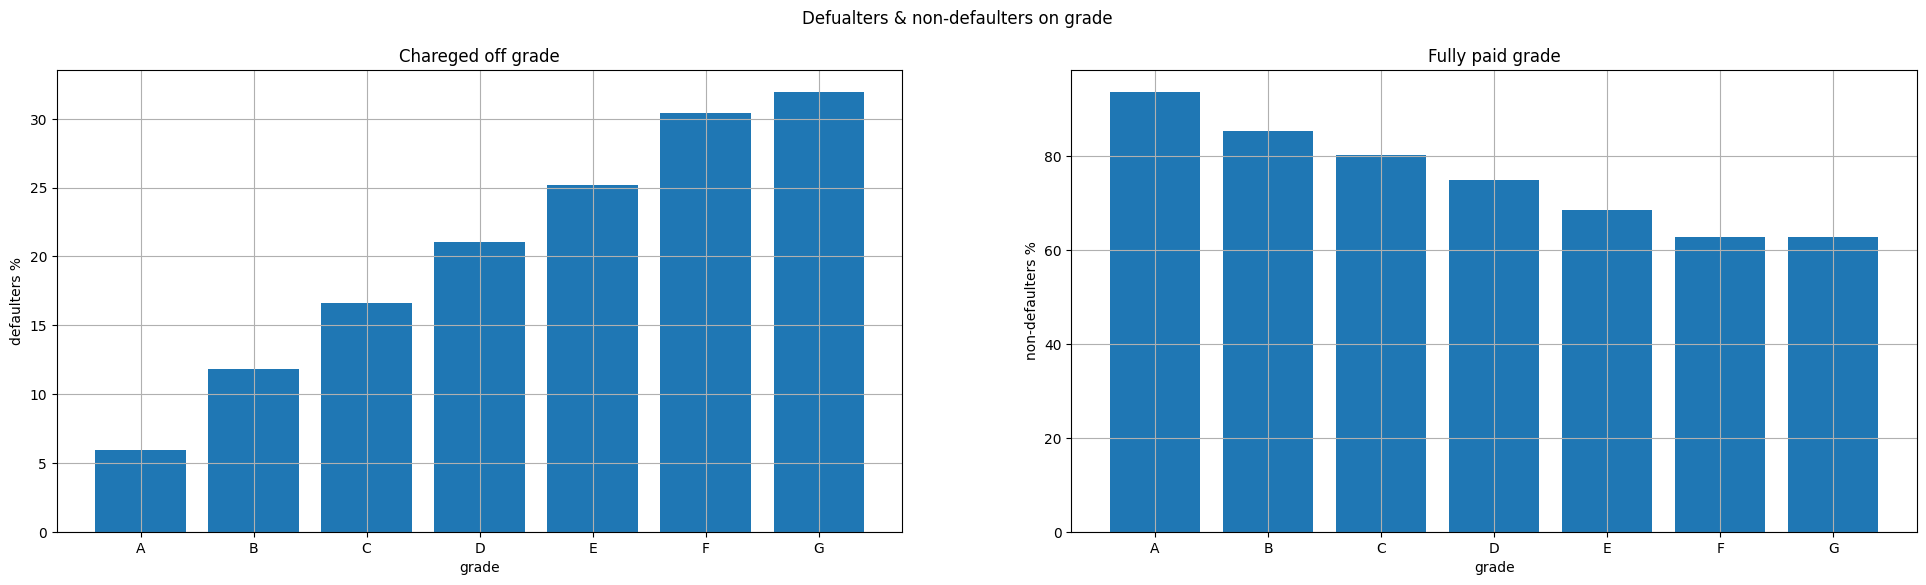

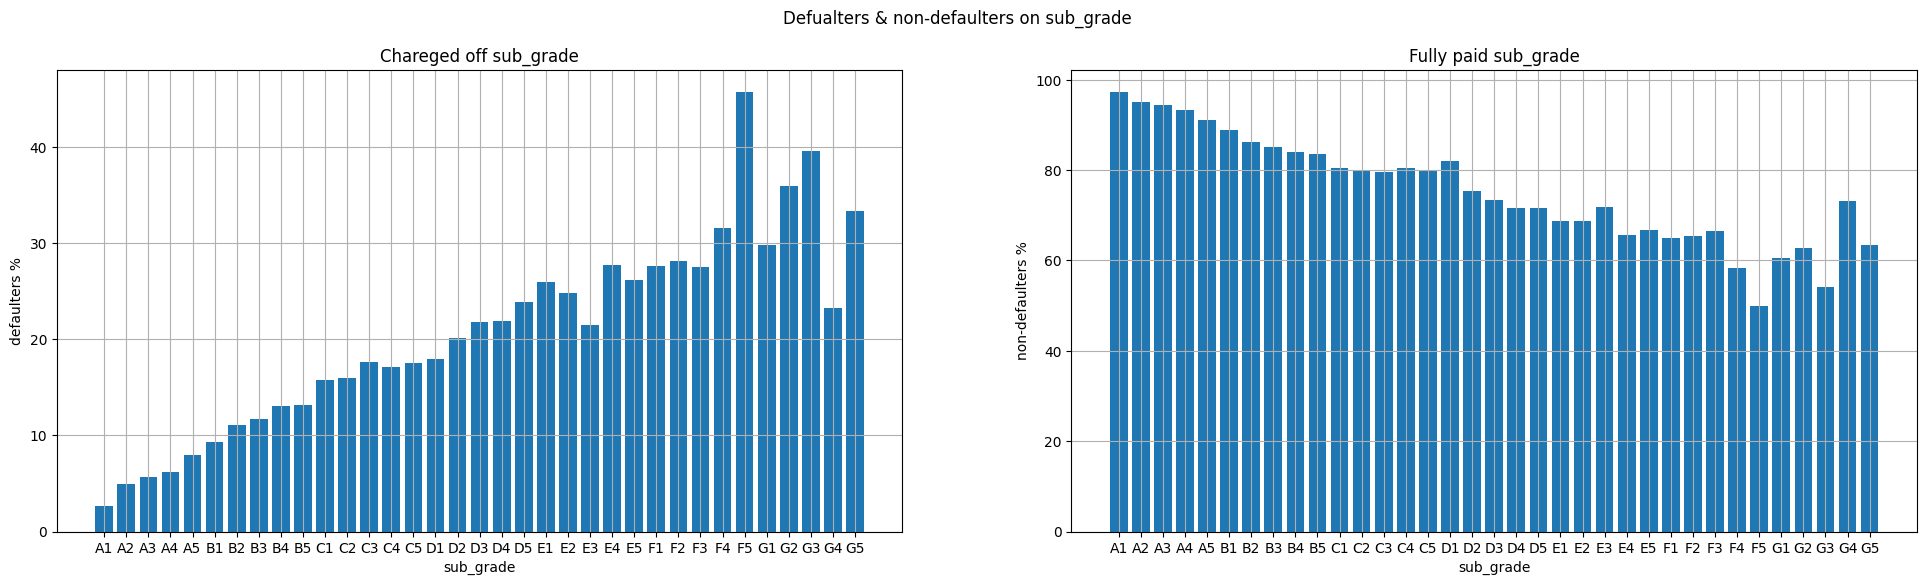

In [ ]:
for typ in ('grade','sub_grade'):
    loan_gr=loan_db.groupby(['loan_status',typ]).agg({'id':'count','loan_amnt':'sum'}).reset_index().rename(columns={'id':'grade_cust'})
    ### Computing total customers state wise ###
    grade_tb=loan_db.groupby([typ]).agg({'id':'count','loan_amnt':'sum'}).reset_index().rename(columns={'id':'total_cust','loan_amnt':'total_loan_amnt'})
    ### Merging them to compute further metrices ###
    grade_db=loan_gr.merge(grade_tb[[typ,'total_cust','total_loan_amnt']],on=typ,how="left")
    ### Proportion of loan_statusn ###
    grade_db['prop']=grade_db['grade_cust']/grade_db['total_cust']

    ### Visualize them
    fig,ax = pp.subplots(1,2,figsize=(24,6))
    fig.suptitle(f'Defualters & non-defaulters on {typ}')
    status=["Charged Off", "Fully Paid"]
    for i,axes in zip(status,ax.ravel()):
        if i=="Charged Off":
            ylabel="defaulters %"
            title=f"Chareged off {typ}"
        else:
            ylabel="non-defaulters %"
            title=f"Fully paid {typ}"
        ### Filtering out total customers with less than 100
        data=grade_db.query(f'loan_status=="{i}"').sort_values([typ,'prop'],ascending=True)
        # print(data)
        axes.bar(data[typ],100*data['prop'])
        axes.set_xlabel(typ)
        axes.set_ylabel(ylabel)
        axes.set_title(title)
        axes.grid()


The graphs on grades & sub_grades shows higher default percentage as the grade ranges A to G. This increasing trend signifies the highest number of defaulters sits in the E to G grades with the percentage range of 25 to 25%. Grade A is the credible one as there's very lower default percentage recorded there.

On the Fully paid graph has clear indcation that customers graded between A and C are more reliable in terms of settling the loan of borrowed money.

#### Distribution of loan amount across grades and sub_grades

Text(0.5, 0.98, 'Distribution of loan amount across grades and sub-grades')

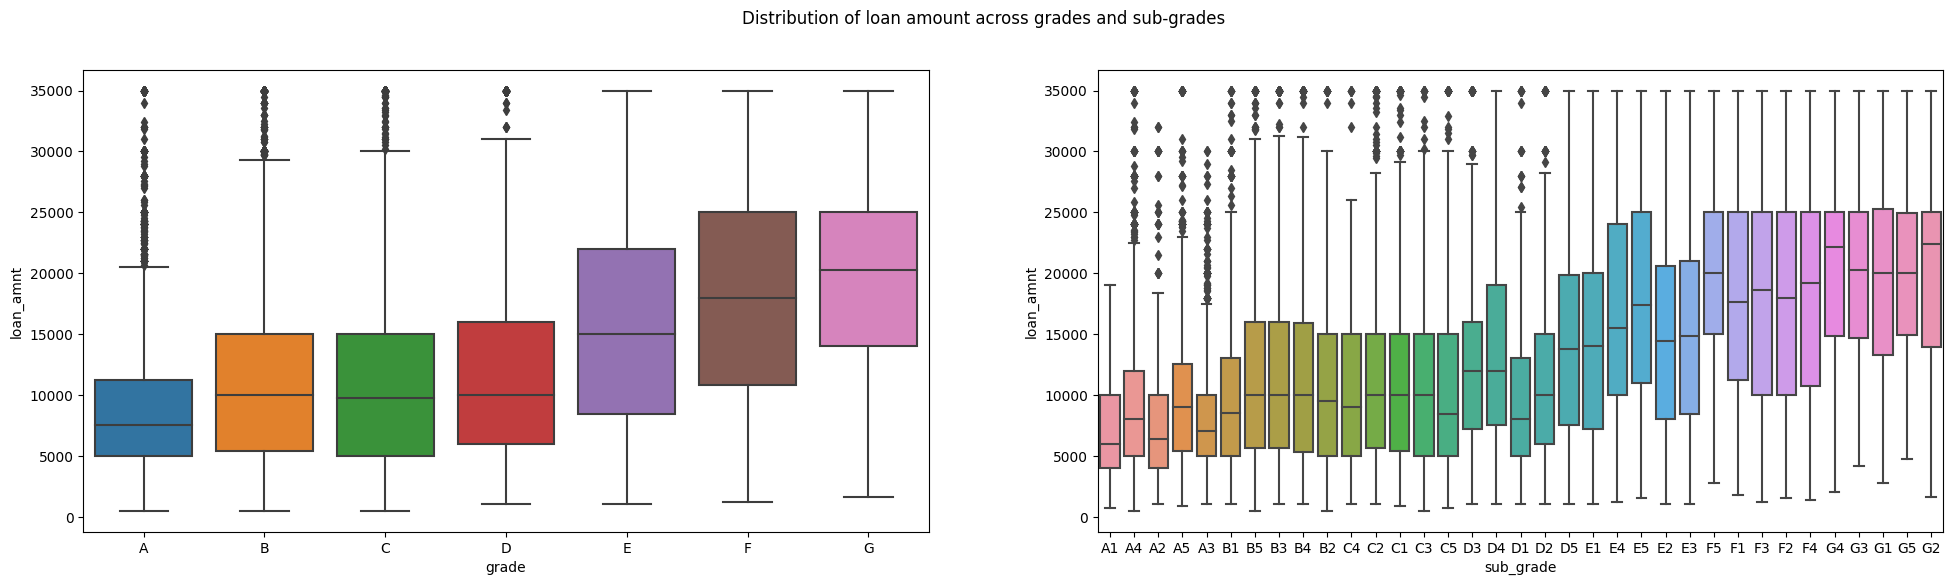

In [ ]:
fig,axes=pp.subplots(1,2,figsize=(24,6))
sns.boxplot(data=loan_db.sort_values('sub_grade'),x='grade',y='loan_amnt',ax=axes[0])
sns.boxplot(data=loan_db.sort_values('grade'),x='sub_grade',y='loan_amnt',ax=axes[1])

fig.suptitle('Distribution of loan amount across grades and sub-grades')

Based on the graphs on grades in the earlier analysis, A to G grades represented credibility of highest to lowest. However, upon looking at their loan mount distribution states, customer graded as G have borrowed huge amount of money in comparison to other grades. The default percentage on grade G could also mean, customers borrowing huge amount of money are more likely to default than other grades.

Grading systerm here is to mark the amount of loan given in the increasing order i.e. Starting from customers graded as A borrowing minimal money compared those who are garaded as G.

Across G grade G1 to G4 sub-grades, the loan amounts are higher compared to other grade and sub-grades type. The interest rate should be imposed higher than the other grades/sub-grades as from the default % analysis on the previous slides shows that grade G's are highly likely to default

#### Distibrution loan amount based on loan status

<AxesSubplot:xlabel='loan_status', ylabel='loan_amnt'>

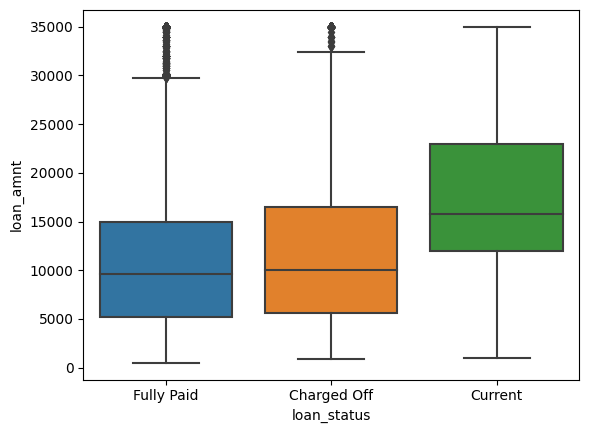

In [ ]:
sns.boxplot(data=loan_db.sort_values('sub_grade'),x='loan_status',y='loan_amnt')

Through the analysis, it has been found that loan with higher interest seems to have more defaulters. Ongoing (current) loaned amount seems to have higher interest and higher loan amount. Hence may potentially increase the defaulters count in the future. Better to reduce their interest rate after certain threshold point of clearancce.

#### Debit To Income (DTI)

The Debt-to-Income (DTI) ratio is a financial measure lenders use to evaluate a borrower’s ability to manage monthly payments and repay debts. It’s expressed as a percentage and calculated by dividing total monthly debt payments by gross monthly income.

1. Low DTI (e.g., below 36%): Generally seen as a positive indicator. Borrowers with a lower DTI are considered less risky since a smaller proportion of their income goes toward debt repayment, suggesting they have more financial flexibility.

2. Moderate DTI (e.g., 36%-43%): Acceptable for many lenders, but some may view this range as moderately risky. Borrowers with a DTI in this range are still likely to be approved for loans, though they may not qualify for the best terms.

3. High DTI (e.g., above 43%): Indicates higher risk to lenders. Borrowers with a high DTI may struggle to manage additional debt, making it more difficult for them to secure new loans or favorable rates.

<AxesSubplot:xlabel='sub_grade', ylabel='dti'>

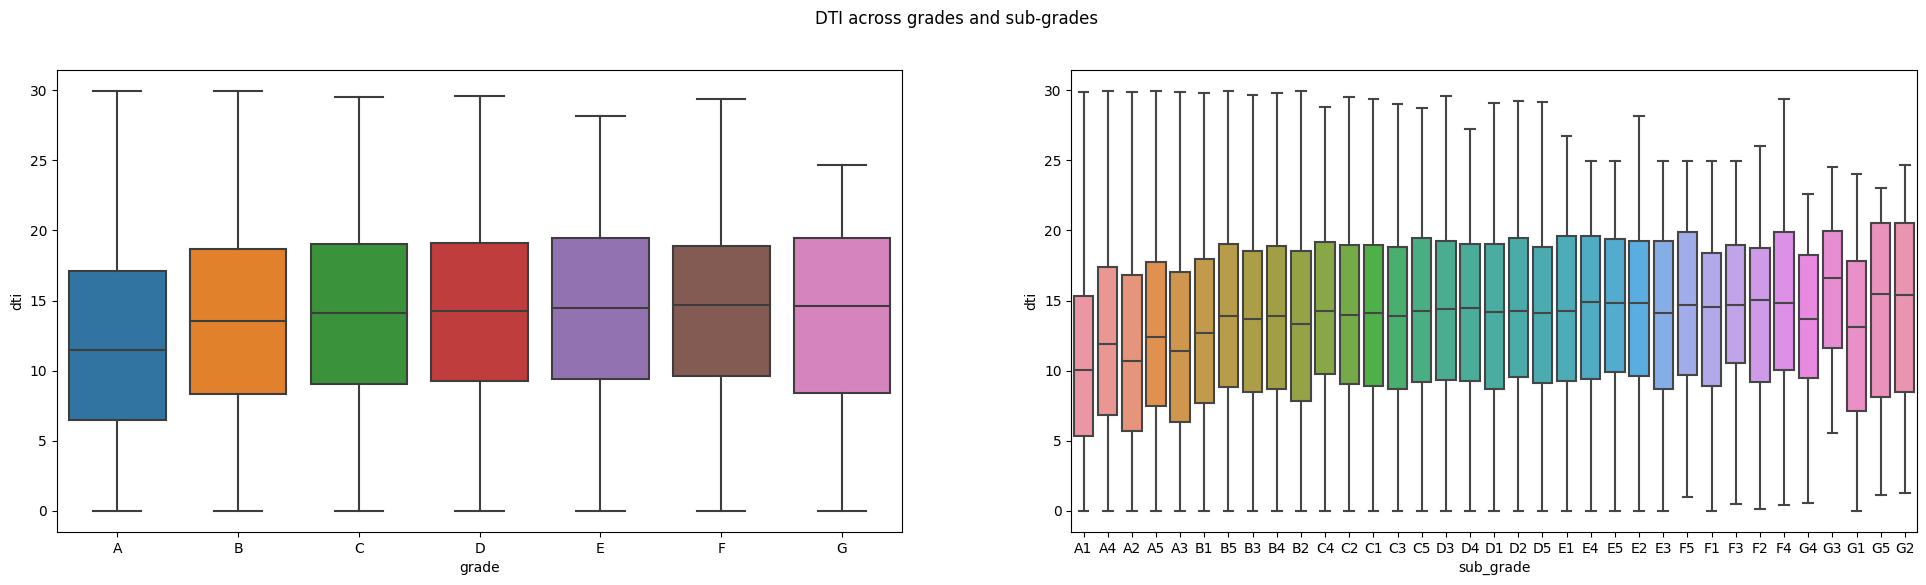

In [ ]:
fig,axes=pp.subplots(1,2,figsize=(24,6))
fig.suptitle("DTI across grades and sub-grades")
sns.boxplot(data=loan_db.sort_values('sub_grade'),x='grade',y='dti',ax=axes[0])
sns.boxplot(data=loan_db.sort_values('grade'),x='sub_grade',y='dti',ax=axes[1])


The risk DTI ratios are the customers with above 43%. Therefore, from the above graphs, lending company has selected customers having good track record of paying off their debts. None of the grades holds any risky customers. However, the lending company should set an internal threshold of DTI when they tend to lend huge amount of money (i.e.) especially in the G grades. For example: To prevent the risk of defaulters on the grade G, they should have lowest DTI which ranging from 0 to 10. Ensuring this would reduce the risk of defaulters on grade G's

#### Does the term of laon has any significance in defaulting?

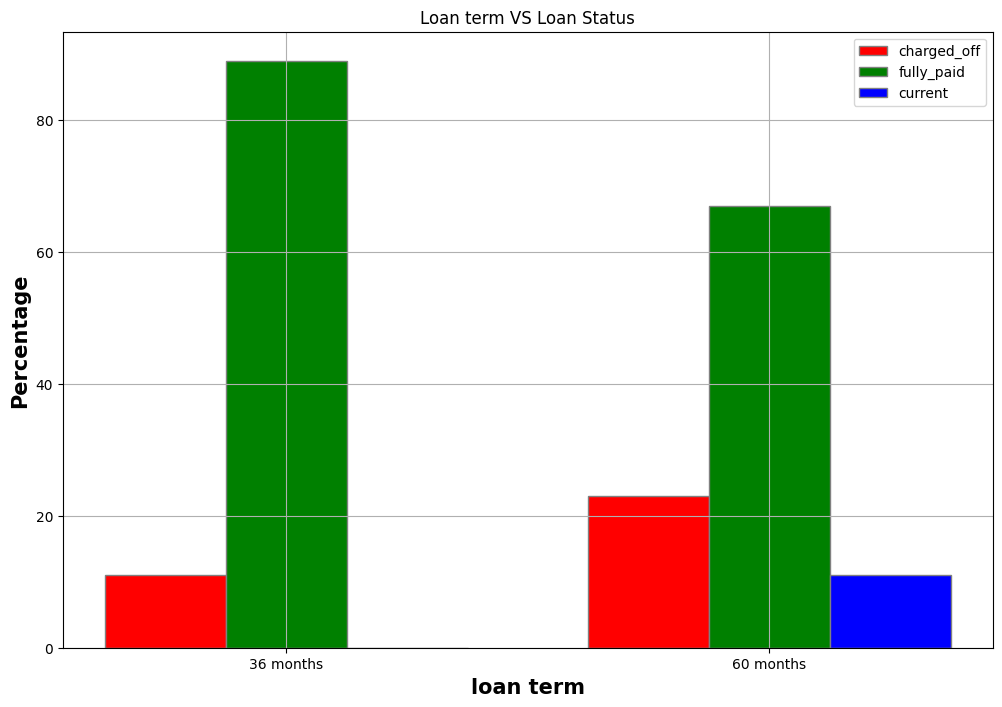

In [ ]:
term_db=loan_db.groupby(['term','loan_status']).agg({'id':'count','loan_amnt':['mean','median','min','max']}).round(0).reset_index().rename(columns={'id':'numb_cust','loan_amnt':'loan_amount'})
tot_tb=loan_db.groupby('term').id.count().reset_index().rename(columns={'id':'tot_cnt'})
term_tb=term_db.merge(tot_tb,on='term',how='left')
term_tb['prop']=term_tb[('numb_cust', 'count')]/term_tb['tot_cnt']
term_tb

barWidth = 0.25
fig = pp.subplots(figsize =(12, 8))


# set height of bar
charged_off = [11,23]
fully_paid = [89,67]
current = [0,11]

# Set position of bar on X axis
br1 = np.arange(len(charged_off))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
pp.bar(br1, charged_off, color ='r', width = barWidth,
        edgecolor ='grey', label ='charged_off')
pp.bar(br2, fully_paid, color ='g', width = barWidth,
        edgecolor ='grey', label ='fully_paid')
pp.bar(br3, current, color ='b', width = barWidth,
        edgecolor ='grey', label ='current')

# Adding Xticks
pp.xlabel('loan term', fontweight ='bold', fontsize = 15)
pp.ylabel('Percentage', fontweight ='bold', fontsize = 15)
pp.xticks([r + barWidth for r in range(len(charged_off))],
        ['36 months','60 months'])
pp.title('Loan term VS Loan Status')
pp.grid()
pp.legend()
pp.show()


Customers with 60 months tenure are more likely to defualt in comparison with 36 months term irrespective of the loan amount that is taken. The bank should offer lesser tenure loans to prevent themselves from financial loss.

#### Relationship between DTI , annual income and loan amount offered

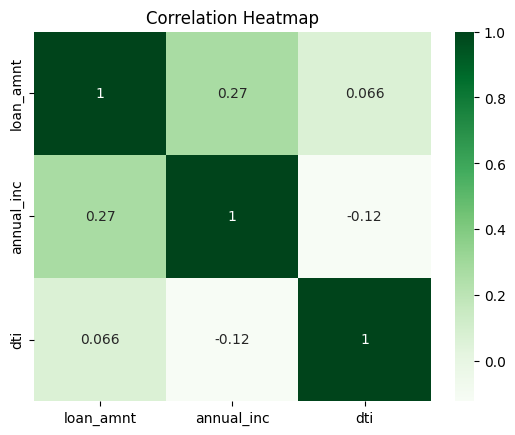

In [ ]:
# Plot heatmap
numerical_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti']
correlation_matrix = loan_data[numerical_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens')
pp.title('Correlation Heatmap')
pp.show()

There's a weak relationship between loan amount, annual_income and DTI. Having strong relationship would prevent the company from financial loss.

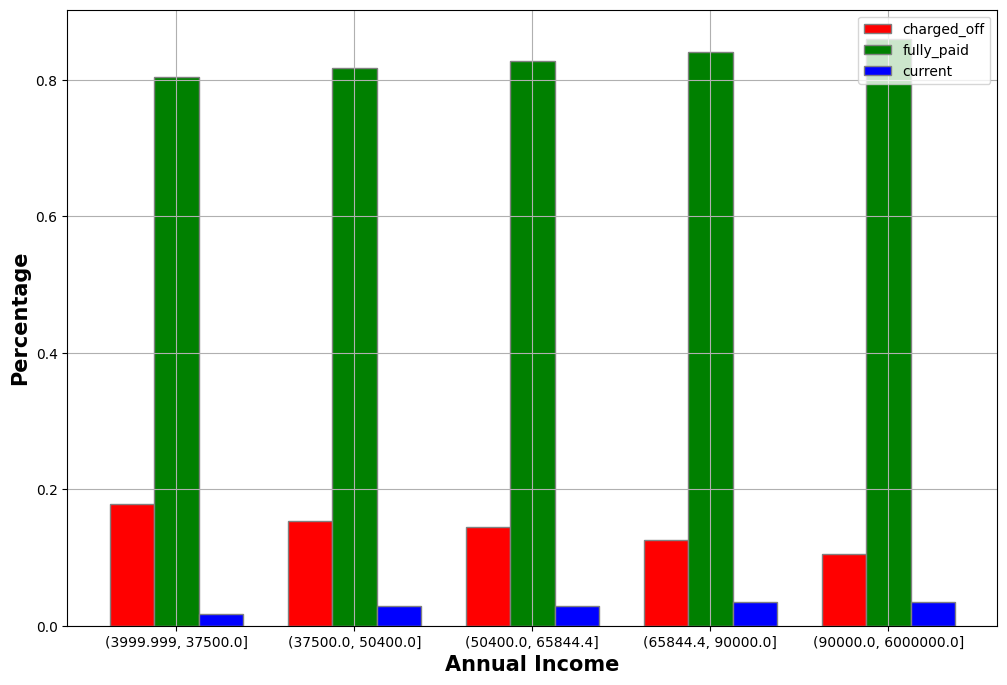

In [ ]:
ann_data=loan_db.groupby(['annual_inc_cat','loan_status']).agg({'loan_amnt':'sum','id':'count'}).reset_index().rename(columns={'loan_amnt':'sum_loan_amnt','id':'num_cust'})
tot_cust_inc=tot_tb=loan_db.groupby('annual_inc_cat').id.count().reset_index().rename(columns={'id':'tot_cnt'})
ann_db=ann_data.merge(tot_cust_inc,on='annual_inc_cat',how='left')
ann_db['prop']=ann_db['num_cust']/ann_db['tot_cnt']
# print(ann_db)

barWidth = 0.25
fig = pp.subplots(figsize =(12, 8))


# set height of bar
charged_off = ann_db.query('loan_status=="Charged Off"').prop.values
fully_paid = ann_db.query('loan_status=="Fully Paid"').prop.values
current = ann_db.query('loan_status=="Current"').prop.values

# Set position of bar on X axis
br1 = np.arange(len(charged_off))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
pp.bar(br1, charged_off, color ='r', width = barWidth,
        edgecolor ='grey', label ='charged_off')
pp.bar(br2, fully_paid, color ='g', width = barWidth,
        edgecolor ='grey', label ='fully_paid')
pp.bar(br3, current, color ='b', width = barWidth,
        edgecolor ='grey', label ='current')

# Adding Xticks
pp.xlabel('Annual Income', fontweight ='bold', fontsize = 15)
pp.ylabel('Percentage', fontweight ='bold', fontsize = 15)
pp.xticks([r + barWidth for r in range(len(charged_off))], ["(3999.999, 37500.0]", "(37500.0, 50400.0]", "(50400.0, 65844.4]", "(65844.4, 90000.0]", "(90000.0, 6000000.0]"]
        )
pp.grid()
pp.legend()
pp.show()


#### Loan status VS Interest Rate

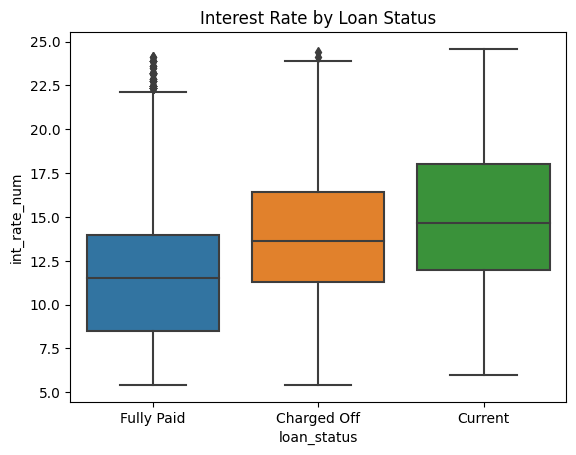

In [ ]:
# Interest Rate
sns.boxplot(data=loan_db,x='loan_status', y='int_rate_num')
pp.title('Interest Rate by Loan Status')
pp.show()

1. On an average defaulted customers has higher interest rate. This shows imposing higher interest rate leads to increased default rate​

2. There's a risk involved in ongoing (current) loan repayment as the rate of interest is higher. To motivate the customer to full repayment of loan, the company can minimize the interest rate after certain amount of principle amount coverage​